In [2]:
import sys
import io
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image
import graphviz
import nni
import torchvision

import torch
import torch.nn as nn
from nni.nas.evaluator import FunctionalEvaluator
from nni.nas.experiment import NasExperiment
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import Subset
from torch_geometric.utils import dense_to_sparse
from nni.nas.hub.pytorch import DARTS as DartsSpace
from nni.nas.space import model_context

sys.path.insert(0, '/pbabkin/main/mipt/nas-for-moe/code')
import nas_moe.utils
import nas_moe.dataset
import nas_moe.moe_arch
import nas_moe.single_arch
import nas_moe.nni_utils
import nas_moe.vae
import nas_moe.surrogate

SEED = 322
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

/usr/local/lib/python3.10/dist-packages/nni/nas/nn/pytorch/layers.py:94: RuntimeWarning: <class 'torch.nn.parameter.Buffer'> is found to be not a nn.Module, which is unexpected. It means your PyTorch version might not be supported.
  warnings.warn(f'{obj} is found to be not a nn.Module, which is unexpected. '
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_name = 'cifar10'
NUM_WORKERS = 4
BATCH_SIZE = 64

In [3]:
if dataset_name == 'mnist':
    h, w = 28, 28
    INPUT_LENGTH = h * w
elif dataset_name == 'cifar10':
    h, w = 32, 32
    INPUT_LENGTH = 3 * h * w

permutation = torch.randperm(INPUT_LENGTH)
reverse_permutation = torch.argsort(permutation)

# Dataset

In [10]:
if dataset_name == 'mnist':
    transform = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_dataset = nas_moe.dataset.DistortedMNIST(
        root='/pbabkin/nas-for-moe/code/data',
        train=True,
        download=True,
        custom_transform=transform,
        distortions=['permutation'],
        permutation=reverse_permutation
    )
    test_dataset = nas_moe.dataset.DistortedMNIST(
        root='/pbabkin/nas-for-moe/code/data',
        train=False,
        download=True,
        custom_transform=transform,
        distortions=['permutation'],
        permutation=reverse_permutation
    )
    # train_dataset = Subset(train_dataset, range(60000, 120000))
    # train_dataset = Subset(train_dataset, range(60000))
elif dataset_name == 'cifar10':
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(32, padding=4),
        transforms.ColorJitter(
            brightness=0.1, 
            contrast=0.1, 
            saturation=0.1,
            hue=0.0  # опционально
        ),
        transforms.RandomRotation(degrees=20),
        transforms.ToTensor(),
    ])

    transform_val = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_dataset = datasets.CIFAR10(
        root='/pbabkin/main/mipt/nas-for-moe/code/data',
        train=True,
        download=True,
        transform=transform_train
    )
    test_dataset = datasets.CIFAR10(
        root='/pbabkin/main/mipt/nas-for-moe/code/data', 
        train=False,
        download=True, 
        transform=transform_val
    )

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


# Architectural space

In [11]:
# model_space = nas_moe.nni_utils.PixelPermutationSpace(
#     width=WIDTH,
#     num_cells=NUM_CELLS,
#     dataset=dataset_name,
#     permutation=reverse_permutation,
#     num_nodes_per_cell=NUM_NODES
# )
model_space = DartsSpace(
    width=16,
    num_cells=3,
    dataset='cifar'
)
arch_dicts = []

# Get archs

In [12]:
arch_dicts = []
archGenerator = nas_moe.single_arch.ParamFilteredArchitectureGenerator(model_space, 8, SEED, threshold=0.7)
arch_dicts += [archGenerator.generate_arch()['architecture'] for _ in range(10000)]

In [13]:
surr = nas_moe.surrogate.GAT(8, 10)
state_dict = torch.load('/pbabkin/main/mipt/nas-for-moe/surr_model_1.pth', map_location=device)
surr.load_state_dict(state_dict, strict=True)
surr.to(device)
print('Model ready')

Model ready


/tmp/ipykernel_182/2375629077.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/pbabkin/main/mipt/nas-for-moe/surr_model_1.pth', map_location=dev

In [14]:
surr.cpu()

def inference_surr(arch):
    graph = nas_moe.graph.Graph(arch, index=0)
    adj, _, features = graph.get_adjacency_matrix()
    
    features = torch.tensor(features, dtype=torch.float)
    adj = torch.tensor(adj, dtype=torch.float)
    
    edge_index, _ = dense_to_sparse(adj)
    
    batch = torch.zeros(features.size(0), dtype=torch.long)
    
    with torch.no_grad():
        output = surr(features, edge_index, batch)
    return output.squeeze(0)

In [15]:
cluster_accs = [inference_surr(arch) for arch in tqdm(arch_dicts)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:09<00:00, 143.58it/s]


In [11]:
stacked = torch.stack(cluster_accs)  # shape (5, 10)
top_values, top_indices = torch.topk(stacked, k=2, dim=0)
max_indices = top_indices[0]
max_values = top_values[0]
print("max indices:", max_indices)
print("max values:", max_values)

chosen_idx = np.unique(max_indices)
print('Chosen indexes: ', chosen_idx)
chosen_archs = [arch_dicts[int(i)] for i in chosen_idx]

max indices: tensor([5367, 1927, 9187, 2582, 5367, 2582, 9231, 5367, 9231, 5367])
max values: tensor([0.8314, 0.7495, 0.7577, 0.7958, 0.7688, 0.7814, 0.7866, 0.7961, 0.7796,
        0.7476])
Chosen indexes:  [1927 2582 5367 9187 9231]


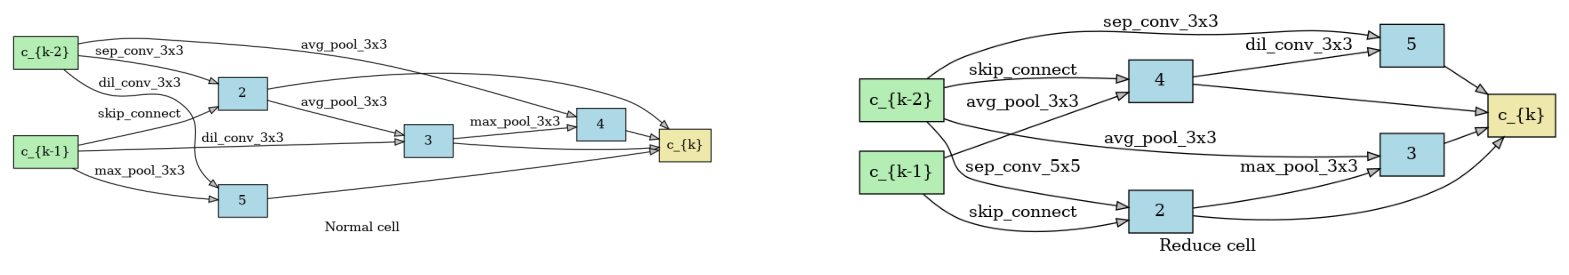

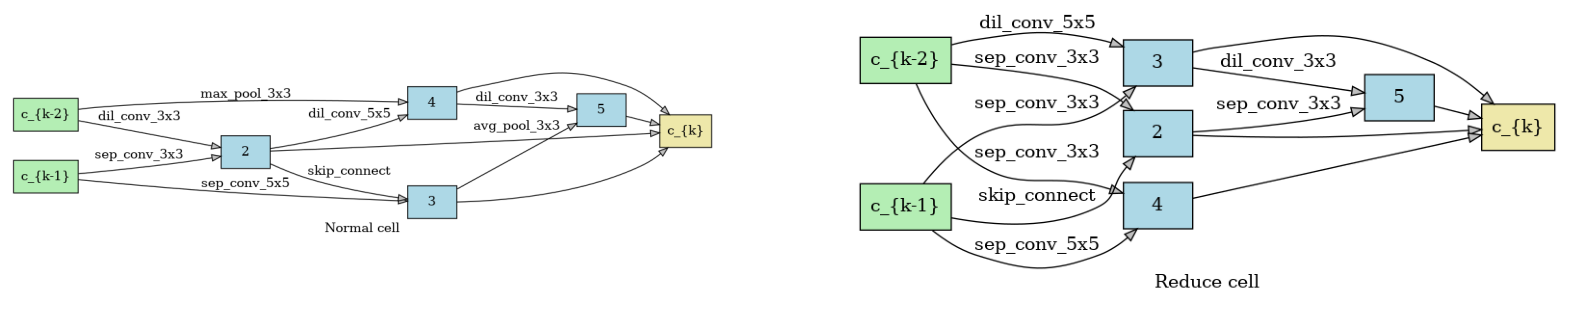

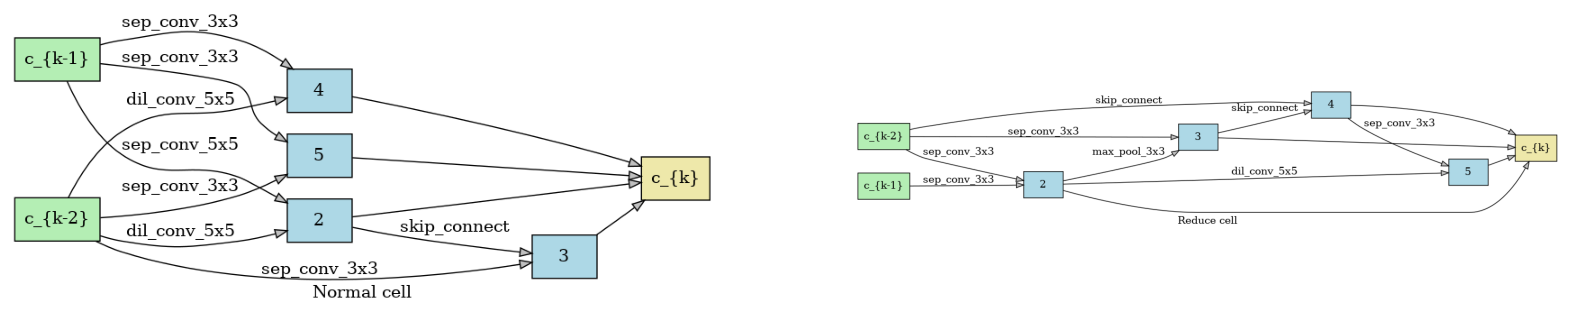

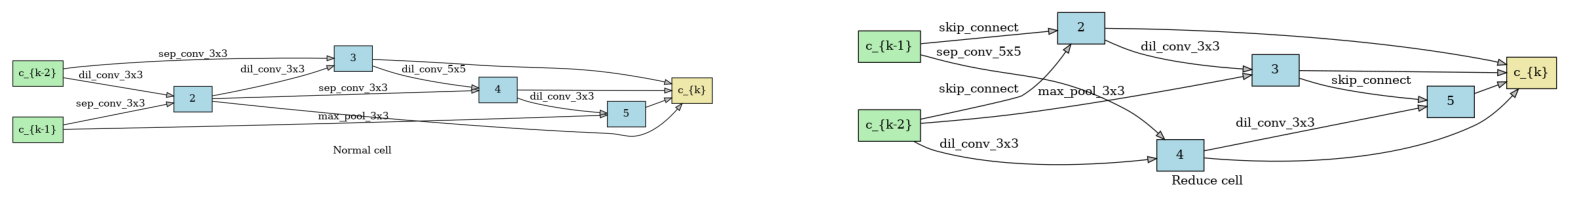

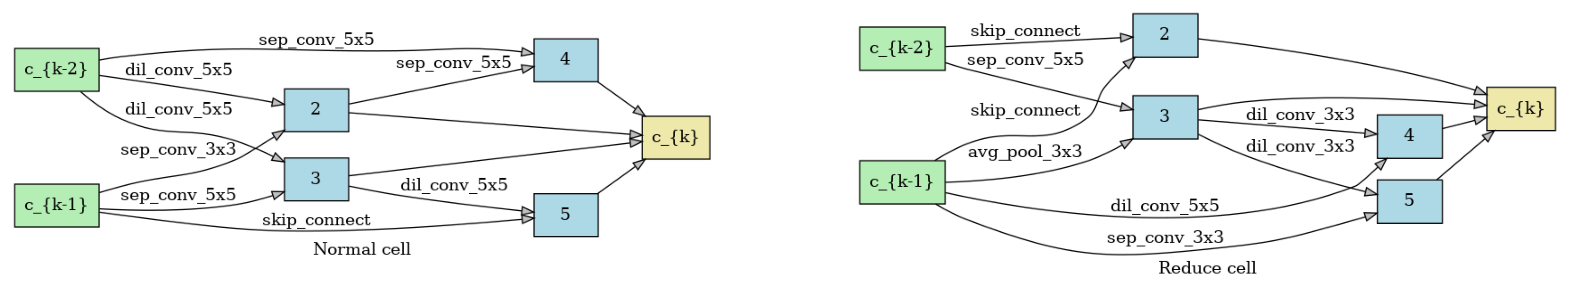

In [12]:
# Archs in MoE
for d in chosen_archs:
    nas_moe.utils.plot_double_cells(d)

# MoE

In [13]:
moe = nas_moe.moe_arch.MoE(chosen_archs,
                           DartsSpace,
                           INPUT_LENGTH,
                           width=model_space.width,
                           num_cells=model_space.num_cells,
                        #    permutation=permutation,
                           dataset='cifar')

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(moe.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
moe.to(device)
num_epochs = 10
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_epochs
)

In [15]:
history = nas_moe.utils.train_model(
    model=moe,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=num_epochs,
    device=device,
    scheduler=scheduler,
    save_checkpoint=True,
    checkpoint_dir="checkpoints",
    verbose=True
)

Epoch 1/10 [Test]: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.25it/s, loss=1.3562, acc=55.91%]


Learning rate: 0.009755
✅ Best model saved to checkpoints/best_moe_model.pth

Epoch 1/10
  Train Loss: 1.558758 | Train Acc: 43.02%
  Test Loss:  1.216750 | Test Acc:  55.91%
----------------------------------------------------------------------


Epoch 2/10 [Test]: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.56it/s, loss=1.2680, acc=60.35%]


Learning rate: 0.009045
✅ Best model saved to checkpoints/best_moe_model.pth

Epoch 2/10
  Train Loss: 1.152595 | Train Acc: 58.84%
  Test Loss:  1.168918 | Test Acc:  60.35%
----------------------------------------------------------------------


Epoch 3/10 [Test]: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 65.92it/s, loss=1.4080, acc=43.60%]


Learning rate: 0.007939

Epoch 3/10
  Train Loss: 1.452410 | Train Acc: 47.10%
  Test Loss:  1.551201 | Test Acc:  43.60%
----------------------------------------------------------------------


Epoch 4/10 [Test]: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 97.10it/s, loss=1.1810, acc=49.23%]


Learning rate: 0.006545

Epoch 4/10
  Train Loss: 1.593497 | Train Acc: 41.00%
  Test Loss:  1.395660 | Test Acc:  49.23%
----------------------------------------------------------------------


Epoch 5/10 [Test]: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 95.41it/s, loss=1.5779, acc=53.55%]


Learning rate: 0.005000

Epoch 5/10
  Train Loss: 1.289915 | Train Acc: 53.28%
  Test Loss:  1.304918 | Test Acc:  53.55%
----------------------------------------------------------------------


Epoch 6/10 [Test]: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.20it/s, loss=1.2548, acc=65.37%]


Learning rate: 0.003455
✅ Best model saved to checkpoints/best_moe_model.pth

Epoch 6/10
  Train Loss: 1.101208 | Train Acc: 60.74%
  Test Loss:  0.995819 | Test Acc:  65.37%
----------------------------------------------------------------------


Epoch 7/10 [Test]: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.42it/s, loss=0.7752, acc=70.04%]


Learning rate: 0.002061
✅ Best model saved to checkpoints/best_moe_model.pth

Epoch 7/10
  Train Loss: 0.985930 | Train Acc: 65.14%
  Test Loss:  0.875665 | Test Acc:  70.04%
----------------------------------------------------------------------


Epoch 8/10 [Test]: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.52it/s, loss=0.6919, acc=71.51%]


Learning rate: 0.000955
✅ Best model saved to checkpoints/best_moe_model.pth

Epoch 8/10
  Train Loss: 0.892415 | Train Acc: 68.37%
  Test Loss:  0.809799 | Test Acc:  71.51%
----------------------------------------------------------------------


Epoch 9/10 [Test]: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.65it/s, loss=0.7256, acc=74.59%]


Learning rate: 0.000245
✅ Best model saved to checkpoints/best_moe_model.pth

Epoch 9/10
  Train Loss: 0.827205 | Train Acc: 70.96%
  Test Loss:  0.725225 | Test Acc:  74.59%
----------------------------------------------------------------------


Epoch 10/10 [Test]: 100%|█████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 91.35it/s, loss=0.6762, acc=75.41%]
/pbabkin/main/mipt/nas-for-moe/code/nas_moe/utils.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file.

Learning rate: 0.000000
✅ Best model saved to checkpoints/best_moe_model.pth

Epoch 10/10
  Train Loss: 0.788759 | Train Acc: 72.30%
  Test Loss:  0.707126 | Test Acc:  75.41%
----------------------------------------------------------------------

✅ Loaded best model from checkpoints/best_moe_model.pth

Training completed!
Best test accuracy: 75.41% (Epoch 10)


# MoE of one arch

In [19]:
same_archs = [chosen_archs[0] for _ in range(len(chosen_idx))]

In [20]:
moe = nas_moe.moe_arch.MoE(same_archs,
                           DartsSpace,
                           INPUT_LENGTH,
                           width=model_space.width,
                           num_cells=model_space.num_cells,
                        #    permutation=permutation,
                           dataset='cifar')

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(moe.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
moe.to(device)
num_epochs = 10
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_epochs
)

In [22]:
history = nas_moe.utils.train_model(
    model=moe,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=num_epochs,
    device=device,
    scheduler=scheduler,
    save_checkpoint=True,
    checkpoint_dir="checkpoints",
    verbose=True
)

Epoch 1/10 [Test]: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 99.40it/s, loss=1.5895, acc=46.70%]


Learning rate: 0.009755
✅ Best model saved to checkpoints/best_moe_model.pth

Epoch 1/10
  Train Loss: 1.552866 | Train Acc: 42.98%
  Test Loss:  1.438005 | Test Acc:  46.70%
----------------------------------------------------------------------


Epoch 2/10 [Test]: 100%|█████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 100.67it/s, loss=1.3979, acc=62.12%]


Learning rate: 0.009045
✅ Best model saved to checkpoints/best_moe_model.pth

Epoch 2/10
  Train Loss: 1.203711 | Train Acc: 57.25%
  Test Loss:  1.093332 | Test Acc:  62.12%
----------------------------------------------------------------------


Epoch 3/10 [Test]: 100%|█████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 102.92it/s, loss=1.2147, acc=48.89%]


Learning rate: 0.007939

Epoch 3/10
  Train Loss: 1.516429 | Train Acc: 44.33%
  Test Loss:  1.392774 | Test Acc:  48.89%
----------------------------------------------------------------------


Epoch 4/10 [Test]: 100%|██████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 98.31it/s, loss=0.9947, acc=60.08%]


Learning rate: 0.006545

Epoch 4/10
  Train Loss: 1.224761 | Train Acc: 56.07%
  Test Loss:  1.100173 | Test Acc:  60.08%
----------------------------------------------------------------------


Epoch 5/10 [Test]: 100%|█████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 102.06it/s, loss=1.4397, acc=62.29%]


Learning rate: 0.005000

Epoch 5/10
  Train Loss: 1.043138 | Train Acc: 62.90%
  Test Loss:  1.130633 | Test Acc:  62.29%
----------------------------------------------------------------------


Epoch 6/10 [Test]: 100%|█████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 100.29it/s, loss=0.7057, acc=69.62%]


Learning rate: 0.003455
✅ Best model saved to checkpoints/best_moe_model.pth

Epoch 6/10
  Train Loss: 0.941481 | Train Acc: 66.76%
  Test Loss:  0.867908 | Test Acc:  69.62%
----------------------------------------------------------------------


Epoch 7/10 [Test]: 100%|█████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 105.80it/s, loss=0.7376, acc=71.63%]


Learning rate: 0.002061
✅ Best model saved to checkpoints/best_moe_model.pth

Epoch 7/10
  Train Loss: 0.862536 | Train Acc: 69.80%
  Test Loss:  0.812007 | Test Acc:  71.63%
----------------------------------------------------------------------


Epoch 8/10 [Test]: 100%|█████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 104.69it/s, loss=0.5418, acc=74.82%]


Learning rate: 0.000955
✅ Best model saved to checkpoints/best_moe_model.pth

Epoch 8/10
  Train Loss: 0.801301 | Train Acc: 71.88%
  Test Loss:  0.719420 | Test Acc:  74.82%
----------------------------------------------------------------------


Epoch 9/10 [Test]: 100%|█████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 101.69it/s, loss=0.6788, acc=76.31%]


Learning rate: 0.000245
✅ Best model saved to checkpoints/best_moe_model.pth

Epoch 9/10
  Train Loss: 0.748476 | Train Acc: 73.80%
  Test Loss:  0.665924 | Test Acc:  76.31%
----------------------------------------------------------------------


Epoch 10/10 [Test]: 100%|████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 103.67it/s, loss=0.5449, acc=77.05%]
/pbabkin/main/mipt/nas-for-moe/code/nas_moe/utils.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file.

Learning rate: 0.000000
✅ Best model saved to checkpoints/best_moe_model.pth

Epoch 10/10
  Train Loss: 0.720868 | Train Acc: 74.73%
  Test Loss:  0.647632 | Test Acc:  77.05%
----------------------------------------------------------------------

✅ Loaded best model from checkpoints/best_moe_model.pth

Training completed!
Best test accuracy: 77.05% (Epoch 10)


# One model

In [23]:
with model_context(chosen_archs[0]):
    expert = DartsSpace(
        width=model_space.width,
        num_cells=model_space.num_cells,
        dataset='cifar'
    )

In [24]:
optimizer = optim.Adam(expert.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
expert.to(device)
num_epochs = 10
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_epochs
)

In [25]:
history = nas_moe.utils.train_model(
    model=expert,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=num_epochs,
    device=device,
    scheduler=scheduler,
    save_checkpoint=True,
    checkpoint_dir="checkpoints",
    verbose=True
)

Epoch 1/10 [Test]: 100%|███████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 140.05it/s, loss=1.6205, acc=55.66%]


Learning rate: 0.009755
✅ Best model saved to checkpoints/best_moe_model.pth

Epoch 1/10
  Train Loss: 1.568853 | Train Acc: 42.71%
  Test Loss:  1.245021 | Test Acc:  55.66%
----------------------------------------------------------------------


Epoch 2/10 [Test]: 100%|███████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 142.74it/s, loss=1.3161, acc=58.96%]


Learning rate: 0.009045
✅ Best model saved to checkpoints/best_moe_model.pth

Epoch 2/10
  Train Loss: 1.178874 | Train Acc: 57.97%
  Test Loss:  1.195412 | Test Acc:  58.96%
----------------------------------------------------------------------


Epoch 3/10 [Test]: 100%|███████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 138.94it/s, loss=1.1192, acc=66.20%]


Learning rate: 0.007939
✅ Best model saved to checkpoints/best_moe_model.pth

Epoch 3/10
  Train Loss: 1.024106 | Train Acc: 63.61%
  Test Loss:  0.948970 | Test Acc:  66.20%
----------------------------------------------------------------------


Epoch 4/10 [Test]: 100%|███████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 141.51it/s, loss=1.0910, acc=69.89%]


Learning rate: 0.006545
✅ Best model saved to checkpoints/best_moe_model.pth

Epoch 4/10
  Train Loss: 0.919745 | Train Acc: 67.57%
  Test Loss:  0.855688 | Test Acc:  69.89%
----------------------------------------------------------------------


Epoch 5/10 [Test]: 100%|███████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 138.73it/s, loss=0.9976, acc=71.83%]


Learning rate: 0.005000
✅ Best model saved to checkpoints/best_moe_model.pth

Epoch 5/10
  Train Loss: 0.831920 | Train Acc: 70.65%
  Test Loss:  0.822224 | Test Acc:  71.83%
----------------------------------------------------------------------


Epoch 6/10 [Test]: 100%|███████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 134.11it/s, loss=0.8694, acc=74.82%]


Learning rate: 0.003455
✅ Best model saved to checkpoints/best_moe_model.pth

Epoch 6/10
  Train Loss: 0.751661 | Train Acc: 73.93%
  Test Loss:  0.721540 | Test Acc:  74.82%
----------------------------------------------------------------------


Epoch 7/10 [Test]: 100%|███████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 134.98it/s, loss=0.6849, acc=77.98%]


Learning rate: 0.002061
✅ Best model saved to checkpoints/best_moe_model.pth

Epoch 7/10
  Train Loss: 0.686734 | Train Acc: 75.97%
  Test Loss:  0.643583 | Test Acc:  77.98%
----------------------------------------------------------------------


Epoch 8/10 [Test]: 100%|███████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 134.08it/s, loss=0.6287, acc=80.12%]


Learning rate: 0.000955
✅ Best model saved to checkpoints/best_moe_model.pth

Epoch 8/10
  Train Loss: 0.633156 | Train Acc: 77.88%
  Test Loss:  0.572981 | Test Acc:  80.12%
----------------------------------------------------------------------


Epoch 9/10 [Test]: 100%|███████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 132.99it/s, loss=0.6009, acc=81.17%]


Learning rate: 0.000245
✅ Best model saved to checkpoints/best_moe_model.pth

Epoch 9/10
  Train Loss: 0.586037 | Train Acc: 79.66%
  Test Loss:  0.546050 | Test Acc:  81.17%
----------------------------------------------------------------------


Epoch 10/10 [Test]: 100%|██████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 134.79it/s, loss=0.6151, acc=81.73%]


Learning rate: 0.000000
✅ Best model saved to checkpoints/best_moe_model.pth

Epoch 10/10
  Train Loss: 0.553577 | Train Acc: 80.73%
  Test Loss:  0.534813 | Test Acc:  81.73%
----------------------------------------------------------------------

✅ Loaded best model from checkpoints/best_moe_model.pth

Training completed!
Best test accuracy: 81.73% (Epoch 10)


In [101]:
for epoch in range(1, num_epochs + 1):
    print(f'Epoch {epoch}/{num_epochs}')
    
    moe.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = moe(images)
        loss = criterion(outputs, labels)
        # lb_loss = moe.compute_load_balancing_loss(images)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    print(f'Train  Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch 1/2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:39<00:00, 47.98it/s]


Train  Loss: 0.3394, Accuracy: 0.8916
Epoch 2/2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:38<00:00, 48.64it/s]

Train  Loss: 0.1793, Accuracy: 0.9447


# One model

In [16]:
from nni.nas.space import model_context
with model_context(arch_dicts[1]):
    expert = nas_moe.nni_utils.PixelPermutationSpace(
        width=WIDTH,
        num_cells=NUM_CELLS,
        dataset=dataset_name,
        permutation=permutation
    )
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(expert.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
expert.to(device)
expert.train()
num_epochs = 2

In [207]:
for epoch in range(1, num_epochs + 1):
    print(f'Epoch {epoch}/{num_epochs}')

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = expert(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    print(f'Train  Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch 1/2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:08<00:00, 116.64it/s]


Train  Loss: 0.3622, Accuracy: 0.8841
Epoch 2/2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:08<00:00, 115.59it/s]

Train  Loss: 0.2048, Accuracy: 0.9365


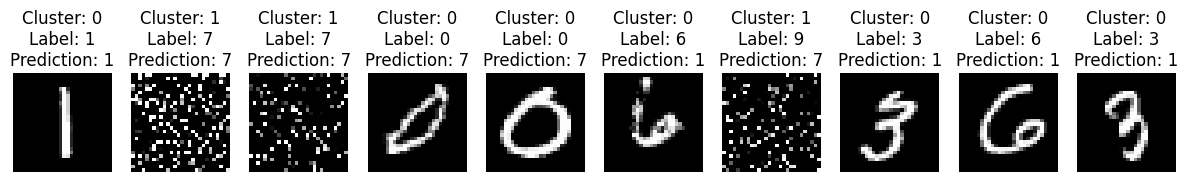

In [209]:
expert.eval()
expert.cpu()
permut = nas_moe.nni_utils.PixelPermutationLayer(permutation)
plt.figure(figsize=(15, 5))
num_images = 10
random_indices = np.random.choice(len(test_dataset), num_images, replace=False)
for i, idx in enumerate(random_indices):
    image, true_label = test_dataset[idx]
    image = image[np.newaxis, :]

    outputs = expert(image).argmax(dim=1)
    
    cluster_label = cluster_labels_test[idx]
    
    plt.subplot(1, num_images, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')  # Подразумевается, что изображение grayscale
    plt.title(f'Cluster: {cluster_label}\nLabel: {true_label}\nPrediction: {outputs.item()}')
    plt.axis('off')
plt.show()

In [46]:
simple_model = nas_moe.utils.SimpleCNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(simple_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
simple_model.to(device)
simple_model.train()
num_epochs = 10

In [47]:
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = simple_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    accuracy = 100. * correct / total
    avg_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:01<00:00, 852.71it/s]


Epoch [1/10], Loss: 0.5752, Accuracy: 81.07%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:01<00:00, 820.71it/s]


Epoch [2/10], Loss: 0.3858, Accuracy: 87.91%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:01<00:00, 878.11it/s]


Epoch [3/10], Loss: 0.3573, Accuracy: 88.97%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:01<00:00, 855.15it/s]


Epoch [4/10], Loss: 0.3398, Accuracy: 89.55%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:01<00:00, 843.14it/s]


Epoch [5/10], Loss: 0.3349, Accuracy: 89.59%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:01<00:00, 846.20it/s]


Epoch [6/10], Loss: 0.3208, Accuracy: 89.94%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:01<00:00, 857.32it/s]


Epoch [7/10], Loss: 0.3103, Accuracy: 90.37%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:01<00:00, 861.82it/s]


Epoch [8/10], Loss: 0.3091, Accuracy: 90.50%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:01<00:00, 820.10it/s]


Epoch [9/10], Loss: 0.3058, Accuracy: 90.36%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:01<00:00, 861.36it/s]

Epoch [10/10], Loss: 0.3024, Accuracy: 90.55%


# Inference MoE

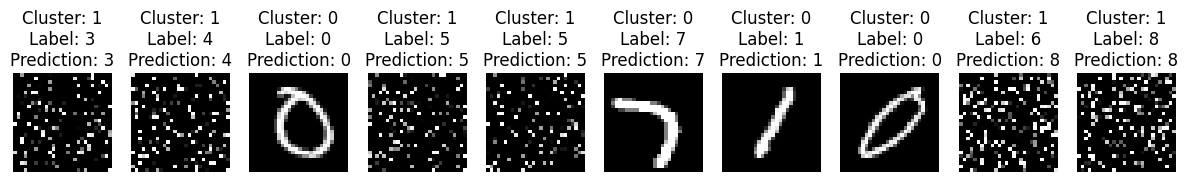

In [69]:
moe.eval()
moe.cpu()
permut = nas_moe.nni_utils.PixelPermutationLayer(permutation)
plt.figure(figsize=(15, 5))
num_images = 10
random_indices = np.random.choice(len(test_dataset), num_images, replace=False)
for i, idx in enumerate(random_indices):
    image, true_label = test_dataset[idx]
    image = image[np.newaxis, :]

    outputs = moe(image).argmax(dim=1)
    
    cluster_label = cluster_labels_test[idx]
    
    plt.subplot(1, num_images, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')  # Подразумевается, что изображение grayscale
    plt.title(f'Cluster: {cluster_label}\nLabel: {true_label}\nPrediction: {outputs.item()}')
    plt.axis('off')
plt.show()

# Cluster

In [ ]:
k = 2

data = []
for i in range(len(train_dataset)):
    x, _ = train_dataset[i]  # Получаем изображение и метку
    data.append(x.numpy().reshape(-1))  # Разворачиваем в вектор
X_train = np.stack(data)
kmeans = KMeans(n_clusters=k, random_state=SEED)
kmeans.fit(X_train)
cluster_labels_train = kmeans.labels_

data = []
for i in range(len(test_dataset)):
    x, _ = test_dataset[i]  # Получаем изображение и метку
    data.append(x.numpy().reshape(-1))  # Разворачиваем в вектор
X_test = np.stack(data)
kmeans = KMeans(n_clusters=k, random_state=SEED)
kmeans.fit(X_test)
cluster_labels_test = kmeans.labels_

TypeError: Invalid shape (3, 32, 32) for image data

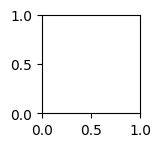

In [ ]:
plt.figure(figsize=(15, 5))
num_images = 10
random_indices = np.random.choice(len(train_dataset), num_images, replace=False)
for i, idx in enumerate(random_indices):
    image, true_label = train_dataset[idx]
    cluster_label = cluster_labels_train[idx]
    
    plt.subplot(1, num_images, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')  # Подразумевается, что изображение grayscale
    plt.title(f'Cluster: {cluster_label}\nLabel: {true_label}')
    plt.axis('off')
plt.show()

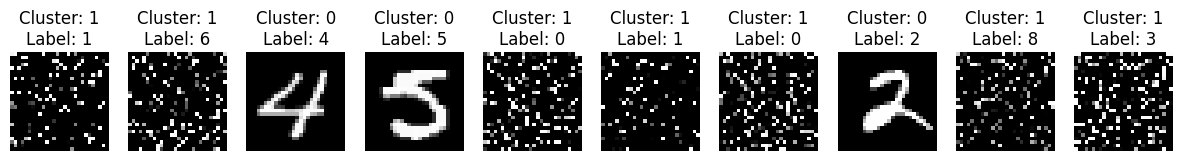

In [ ]:
permut = nas_moe.nni_utils.PixelPermutationLayer(permutation)
plt.figure(figsize=(15, 5))
num_images = 10
random_indices = np.random.choice(len(train_dataset), num_images, replace=False)
for i, idx in enumerate(random_indices):
    image, true_label = train_dataset[idx]
    image = permut(image[np.newaxis, :])
    cluster_label = cluster_labels_train[idx]
    
    plt.subplot(1, num_images, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')  # Подразумевается, что изображение grayscale
    plt.title(f'Cluster: {cluster_label}\nLabel: {true_label}')
    plt.axis('off')
plt.show()